<a href="https://colab.research.google.com/github/sgraziabile/Premier-League-ML/blob/main/Proyecto2_Graziabile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 - Inteligencia Artificial 2024 🤖

### Comisión NRO 8 - STÉFANO GRAZIABILE


---



# Carga y análisis de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers, Input

from google.colab import files

#Get the datasets
!wget -O football_test.csv "https://www.dropbox.com/scl/fi/zsy23qeei8qlees32c91a/football_test.csv?rlkey=jx8iu1suzda87fxv9li8lb7g6&st=micbd9kp&dl=0"
!wget -O football_train.csv "https://www.dropbox.com/scl/fi/id0u00m6azk2r8z7k3msw/football_train.csv?rlkey=i7mcdyrjyzpd1rgyztqjaeyra&st=9svqgosq&dl=0"

--2024-11-18 05:26:16--  https://www.dropbox.com/scl/fi/zsy23qeei8qlees32c91a/football_test.csv?rlkey=jx8iu1suzda87fxv9li8lb7g6&st=micbd9kp&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1b7613401756458a1465aa7ae0.dl.dropboxusercontent.com/cd/0/inline/CektF7kwrsPmk82yx8SFgqlrj3SeAWcTwIcF7HgYZ8nwSINFNtpURVoQr6-LGzNxh_bas9bLhh3PUxA24N1abjQJO9wB0WE_-nnFOfelFHvhIgr0Bp1MNZLjRG9qwOf5SCOgQLGVw_dYpslYXrxij75o/file# [following]
--2024-11-18 05:26:18--  https://uc1b7613401756458a1465aa7ae0.dl.dropboxusercontent.com/cd/0/inline/CektF7kwrsPmk82yx8SFgqlrj3SeAWcTwIcF7HgYZ8nwSINFNtpURVoQr6-LGzNxh_bas9bLhh3PUxA24N1abjQJO9wB0WE_-nnFOfelFHvhIgr0Bp1MNZLjRG9qwOf5SCOgQLGVw_dYpslYXrxij75o/file
Resolving uc1b7613401756458a1465aa7ae0.dl.dropboxusercontent.com (uc1b7613401756458a1465aa7ae0.dl.dropboxusercontent.com)

In [ ]:
#Load the dataset with Pandas
df_premier = pd.read_csv('football_train.csv')

print("Examples: {}\nNumber of columns: {}".format(df_premier.shape[0], df_premier.shape[1]))
print()

print("Dataset metrics: {}".format(list(df_premier.columns)))

#Dataset basic info
df_premier.info()


Examples: 5320
Number of columns: 22

Dataset metrics: ['Team', 'Goals', 'Shots', 'Shots_on_target', 'Corners', 'Fouls_commited', 'Offsides', 'Yellow_cards', 'Red_cards', 'Corners_received', 'Fouls_received', 'Shots_received', 'Shots_on_target_received', 'Goals_received', 'Played_Matches', 'Season', 'City', 'Stadium', 'Stadium_capacity', 'Ownership', 'Dominant_team', 'Position']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Team                      5320 non-null   object 
 1   Goals                     4856 non-null   float64
 2   Shots                     5320 non-null   int64  
 3   Shots_on_target           5320 non-null   int64  
 4   Corners                   5320 non-null   int64  
 5   Fouls_commited            5320 non-null   int64  
 6   Offsides                  5320 non-null   int64  
 7   Yellow_card

In [ ]:
#Columns with null values
def print_null_columns(df_premier):
  print("Columns with null values: ")
  for column in df_premier.columns:
      num_nulls = df_premier[column].isna().sum()
      if num_nulls > 0:
          print(f"-> The column {column} has {num_nulls} nulls.")
  print()
print_null_columns(df_premier)

Columns with null values: 
-> The column Goals has 464 nulls.
-> The column Yellow_cards has 3163 nulls.
-> The column Red_cards has 291 nulls.
-> The column Position has 272 nulls.



In [ ]:
#Categoric columns
def print_categorical_columns(df_premier):
  print("Columnas categóricas:")
  for column in df_premier.columns:
      if df_premier[column].dtype == 'object':
          values = df_premier[column].unique()
          print(f"-> The column {column} has {len(values)} different values.")
  print()

# Procesamiento de los datos

In [ ]:
#Fills the NaN values for column Goals.
#The filler value is the average goals scored for that team, that season, until the previous matchday.
def fill_null_goals(df_aux):
  #Fill NaN values for first matchday of a team in a season
  df_aux.loc[(df_aux['Played_Matches'] == 1) & (df_aux['Goals'].isnull()), 'Goals'] = 0
  #Get goals from previous and next matchday
  df_aux['previous_goals'] = df_aux.groupby(['Team', 'Season'])['Goals'].shift(1)
  df_aux['next_goals'] = df_aux.groupby(['Team', 'Season'])['Goals'].shift(-1)

  df_aux['previous_matches'] = df_aux.groupby(['Team', 'Season'])['Played_Matches'].shift(1)
  df_aux['avg_goals'] = df_aux['previous_goals'] / df_aux['previous_matches']
  #Replace NaN values in Goals
  df_aux['add_goals'] = df_aux['previous_goals'] + df_aux['avg_goals']

  df_aux['Goals'] = np.where(df_aux['Goals'].isnull(),
    np.where(df_aux['next_goals'].isnull(),
      df_aux['add_goals'],
      np.where(df_aux['add_goals'] < df_aux['next_goals'],
            df_aux['add_goals'],
            df_aux['next_goals']),
      ),
      df_aux['Goals']
  )

  # Drop temporary columns used for calculation
  df_aux = df_aux.drop(columns=['previous_goals', 'next_goals','add_goals','avg_goals','previous_matches'])
  return df_aux


In [ ]:
#The NaN values for Red_cards column are filled with the mean between last matchday's red card and the next matchday.
def fill_null_red_cards(df_aux):
  #Fill NaN values for the first matchday (Played_Matches == 1) with 0
  df_aux.loc[(df_aux['Played_Matches'] == 1) & (df_aux['Red_cards'].isnull()), 'Red_cards'] = 0

  #Get the previous matchday's cumulative red cards for each team in a season
  df_aux['previous_red_cards'] = df_aux.groupby(['Team', 'Season'])['Red_cards'].shift(1)
  df_aux['next_red_cards'] = df_aux.groupby(['Team', 'Season'])['Red_cards'].shift(-1)

  df_aux['avg_red_cards'] = (df_aux['next_red_cards'] - df_aux['previous_red_cards']) / 2
  df_aux['fill_red_cards'] = df_aux['previous_red_cards'] + df_aux['avg_red_cards']

  #Fill NaN values for Red_cards
  #If the calculated value exceeds the next value, it fills it with the previous one
  df_aux['Red_cards'] = np.where(df_aux['Red_cards'].isnull(),
    np.where(df_aux['next_red_cards'].isnull(),
      df_aux['previous_red_cards'],
      df_aux['fill_red_cards']
      ),
      df_aux['Red_cards']
  )

  df_aux = df_aux.drop(columns=['previous_red_cards','next_red_cards','fill_red_cards','avg_red_cards'])

  return df_aux



In [ ]:
#Fills null Positions with the last recorded position for that team in that season.
def fill_null_positions(df_aux):
    df_aux['Position'] = df_aux.groupby(['Team', 'Season'])['Position'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
    return df_aux


In [ ]:
#Fills the invalid Dominant_team column values with the most common value for that team that season.
def replace_invalid_dominant(df_aux):
  df_aux['Dominant_team'] = df_aux.groupby(['Team', 'Season'])['Dominant_team'].transform(lambda group: group.replace('0',group.mode()[0]))
  return df_aux

In [ ]:
def delete_reduntant_columns(df_aux):
  df_aux = df_aux.drop(columns=['City','Stadium','Ownership','Stadium_capacity','Yellow_cards','Played_Matches','Offsides','Team'])
  return df_aux

In [ ]:
#Filling NaN values in the dataset
df_premier_goals = df_premier.copy()
while(df_premier_goals['Goals'].isnull().any()):
  df_premier_goals = fill_null_goals(df_premier_goals)
print_null_columns(df_premier_goals)

df_premier_red_cards = df_premier_goals.copy()
while(df_premier_red_cards['Red_cards'].isnull().any()):
  df_premier_red_cards = fill_null_red_cards(df_premier_goals)
print_null_columns(df_premier_red_cards)

df_premier_positions = fill_null_positions(df_premier_red_cards)
print_null_columns(df_premier_positions)

df_premier_dominant = replace_invalid_dominant(df_premier_positions)
data_info = df_premier_dominant.copy()

df_premier_util = delete_reduntant_columns(df_premier_dominant)

print_null_columns(df_premier_util)

df_premier_util

Columns with null values: 
-> The column Yellow_cards has 3163 nulls.
-> The column Red_cards has 291 nulls.
-> The column Position has 272 nulls.

Columns with null values: 
-> The column Yellow_cards has 3163 nulls.
-> The column Position has 272 nulls.

Columns with null values: 
-> The column Yellow_cards has 3163 nulls.

Columns with null values: 



,Goals,Shots,Shots_on_target,Corners,Fouls_commited,Red_cards,Corners_received,Fouls_received,Shots_received,Shots_on_target_received,Goals_received,Season,Dominant_team,Position
0,0.0,14,4,6,14,0.0,3,8,12,3,0,1617,not_dominant,media-tabla
1,0.0,26,7,14,28,0.0,13,13,29,9,3,1617,not_dominant,media-tabla
2,0.0,37,12,20,37,0.0,16,22,38,10,3,1617,not_dominant,media-tabla
3,0.0,54,15,29,50,0.0,20,33,47,14,6,1617,not_dominant,media-tabla
4,1.0,75,22,32,62,0.0,22,48,53,18,9,1617,not_dominant,media-tabla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,52.0,353,142,147,325,1.0,196,364,509,189,43,2223,not_dominant,media-tabla
5316,54.0,367,150,153,331,1.0,196,377,514,192,44,2223,not_dominant,media-tabla
5317,55.0,379,153,156,341,1.0,202,394,528,196,45,2223,not_dominant,media-tabla
5318,56.0,388,156,162,349,1.0,206,405,541,200,46,2223,not_dominant,media-tabla


In [ ]:
#Get dataset info
print_null_columns(df_premier_util)
print()
df_premier_util.info()
df_premier_util.head(140)

Columns with null values: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Goals                     5320 non-null   float64
 1   Shots                     5320 non-null   int64  
 2   Shots_on_target           5320 non-null   int64  
 3   Corners                   5320 non-null   int64  
 4   Fouls_commited            5320 non-null   int64  
 5   Red_cards                 5320 non-null   float64
 6   Corners_received          5320 non-null   int64  
 7   Fouls_received            5320 non-null   int64  
 8   Shots_received            5320 non-null   int64  
 9   Shots_on_target_received  5320 non-null   int64  
 10  Goals_received            5320 non-null   int64  
 11  Season                    5320 non-null   int64  
 12  Dominant_team             5320 non-null   object 
 13  Position                  5320 non

,Goals,Shots,Shots_on_target,Corners,Fouls_commited,Red_cards,Corners_received,Fouls_received,Shots_received,Shots_on_target_received,Goals_received,Season,Dominant_team,Position
0,0.0,14,4,6,14,0.0,3,8,12,3,0,1617,not_dominant,media-tabla
1,0.0,26,7,14,28,0.0,13,13,29,9,3,1617,not_dominant,media-tabla
2,0.0,37,12,20,37,0.0,16,22,38,10,3,1617,not_dominant,media-tabla
3,0.0,54,15,29,50,0.0,20,33,47,14,6,1617,not_dominant,media-tabla
4,1.0,75,22,32,62,0.0,22,48,53,18,9,1617,not_dominant,media-tabla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,24.0,216,75,114,226,0.0,103,238,299,110,39,1617,not_dominant,media-tabla
136,24.0,225,78,115,235,0.0,110,252,318,116,40,1617,not_dominant,media-tabla
137,25.0,230,81,118,247,0.0,120,265,332,122,41,1617,not_dominant,media-tabla
138,25.0,243,84,126,254,0.0,123,275,344,126,43,1617,not_dominant,media-tabla


In [ ]:
#Categoric columns values
unique_positions = df_premier_util['Position'].unique()
print(unique_positions)
print()

unique_dominant_team = df_premier_util['Dominant_team'].unique()
print(unique_dominant_team)
print()

seasons = df_premier_util['Season'].unique()
print(seasons)
print()

['media-tabla' '5-a-7' 'descenso' 'top-4']

['not_dominant' 'dominant' 'very_dominant']

[1617 1718 1819 1920 2021 2122 2223]



In [ ]:
#Encode the Positions category
def encode_positions(df_aux):
  positions_map = {"top-4": 0, "5-a-7": 1, "media-tabla": 2, "descenso": 3}
  df_aux['Position'] = df_aux['Position'].map(positions_map)
  return df_aux


In [ ]:
#Encode the Dominant_team category
def encode_dominant_team(df_aux):
  df_aux = pd.get_dummies(df_aux, columns=['Dominant_team'],dtype=int)
  return df_aux


In [ ]:
#Apply encoding to categoric columns
df_premier_encode1 = encode_positions(df_premier_util)
df_premier_encode2 = encode_dominant_team(df_premier_encode1)

df_premier_dataset = df_premier_encode2.copy()
df_premier_encode2

,Goals,Shots,Shots_on_target,Corners,Fouls_commited,Red_cards,Corners_received,Fouls_received,Shots_received,Shots_on_target_received,Goals_received,Season,Position,Dominant_team_dominant,Dominant_team_not_dominant,Dominant_team_very_dominant
0,0.0,14,4,6,14,0.0,3,8,12,3,0,1617,2,0,1,0
1,0.0,26,7,14,28,0.0,13,13,29,9,3,1617,2,0,1,0
2,0.0,37,12,20,37,0.0,16,22,38,10,3,1617,2,0,1,0
3,0.0,54,15,29,50,0.0,20,33,47,14,6,1617,2,0,1,0
4,1.0,75,22,32,62,0.0,22,48,53,18,9,1617,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,52.0,353,142,147,325,1.0,196,364,509,189,43,2223,2,0,1,0
5316,54.0,367,150,153,331,1.0,196,377,514,192,44,2223,2,0,1,0
5317,55.0,379,153,156,341,1.0,202,394,528,196,45,2223,2,0,1,0
5318,56.0,388,156,162,349,1.0,206,405,541,200,46,2223,2,0,1,0


In [ ]:
#Generate validation set: All premier league matchdays fron the 2223 season
testing_set = pd.read_csv('football_test.csv')
df_premier_dataset = df_premier_encode2.copy()

val_size = 0.15

training_set, validation_set = train_test_split(df_premier_dataset,test_size = val_size, random_state=42)


print("Training data:\n\tExamples (rows): {}\n\tAttributes (columns): {}\n".format(training_set.shape[0], training_set.shape[1]))
print("Validation Data:\n\tExamples (rows): {}\n\tAttributes (columns): {}\n".format(validation_set.shape[0], validation_set.shape[1]))
print("Test Data:\n\tExamples (rows): {}\n\tAttributes (columns): {}".format(testing_set.shape[0], testing_set.shape[1]))

Training data:
	Examples (rows): 4522
	Attributes (columns): 16

Validation Data:
	Examples (rows): 798
	Attributes (columns): 16

Test Data:
	Examples (rows): 20
	Attributes (columns): 21


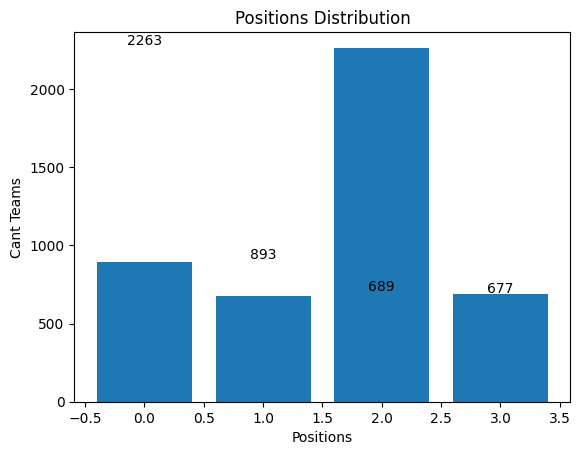

In [ ]:
#Histogram to display positions
position_counter = training_set['Position'].value_counts()

plt.bar(position_counter.index, position_counter.values)

# Add text etiquetes for each bar
for i, count in enumerate(position_counter.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Add etiquetes to axis
plt.xlabel('Positions')
plt.ylabel('Cant Teams')

plt.ylim(0, position_counter.values.max() + 100)

plt.title('Positions Distribution')
# Display the histogram
plt.show()

# Desarrollo de un Árbol de Decisión

In [ ]:
#Build the decision tree
target_train = training_set['Position']
features_train = training_set.drop(columns=['Position'])

target_val = validation_set['Position']
features_val = validation_set.drop(columns=['Position'])

decision_tree = DecisionTreeClassifier(max_depth = 7)
decision_tree.fit(features_train, target_train)

print(f"Tree depth: \n{decision_tree.get_depth()}\n")

print(f"Tree leaves: \n{decision_tree.get_n_leaves()}\n")

print(f"Number of attributes: \n{decision_tree.n_features_in_}\n")

print(f"Total num of attributes: \n{len(features_train.columns.values)}\n")

Tree depth: 
7

Tree leaves: 
74

Number of attributes: 
15

Total num of attributes: 
15



In [ ]:
#Get predictions
predictions = decision_tree.predict(features_val)
predictions2 = decision_tree.predict(features_train)

print("Validation Set Accuracy: ", accuracy_score(target_val, predictions))
print()

print(classification_report(target_val, predictions))
print()

print("Train Set Accuracy: ", accuracy_score(target_train, predictions2))
print()

print(classification_report(target_train, predictions2))

Validation Set Accuracy:  0.7669172932330827

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       171
           1       0.64      0.50      0.56       121
           2       0.76      0.91      0.82       397
           3       0.76      0.57      0.65       109

    accuracy                           0.77       798
   macro avg       0.76      0.68      0.71       798
weighted avg       0.77      0.77      0.76       798


Train Set Accuracy:  0.7695709862892526

              precision    recall  f1-score   support

           0       0.91      0.79      0.84       893
           1       0.67      0.51      0.58       677
           2       0.75      0.92      0.82      2263
           3       0.79      0.51      0.62       689

    accuracy                           0.77      4522
   macro avg       0.78      0.68      0.72      4522
weighted avg       0.77      0.77      0.76      4522



In [ ]:
#Functions for filling the testing set
def fill_red_cards_test(test_set, train_set):
  avg_red_cards = train_set.groupby(['Team', 'Played_Matches'])['Red_cards'].mean()

  def fill_red_cards_row(row):
    if(pd.isnull(row['Red_cards'])):
      return avg_red_cards.get((row['Team'], row['Played_Matches']), 0)
    else:
      return row['Red_cards']

  test_set['Red_cards'] = test_set.apply(fill_red_cards_row, axis=1)
  return test_set

In [ ]:
testing_set_util = testing_set.copy()
training_set = data_info.copy()
testing_set_util = fill_red_cards_test(testing_set_util, training_set)
team_column = testing_set_util['Team']
testing_set_util = delete_reduntant_columns(testing_set_util)
display_test_set = testing_set_util.copy()
testing_set_util = encode_dominant_team(testing_set_util)
testing_set_util


predictions = decision_tree.predict(testing_set_util)
testing_set_util['Expected_position'] = predictions
predictions_set = testing_set_util.copy()
predictions_set['Team'] = team_column
tree_predictions = predictions.copy()
print(predictions_set[['Team','Season','Expected_position']])

                Team  Season  Expected_position
0            Arsenal    2324                  0
1        Aston Villa    2324                  2
2        Bournemouth    2324                  3
3          Brentford    2324                  2
4           Brighton    2324                  2
5            Burnley    2324                  3
6            Chelsea    2324                  2
7     Crystal Palace    2324                  2
8            Everton    2324                  2
9             Fulham    2324                  2
10         Liverpool    2324                  0
11             Luton    2324                  3
12          Man City    2324                  0
13        Man United    2324                  2
14         Newcastle    2324                  2
15     Nott'm Forest    2324                  3
16  Sheffield United    2324                  3
17         Tottenham    2324                  2
18          West Ham    2324                  2
19            Wolves    2324            

# Desarrollo de una Red Neuronal Artificial

In [ ]:
#Encode the cateogory names
encoder = OneHotEncoder(sparse_output=False)
target_train_encoded = encoder.fit_transform(target_train.values.reshape(-1, 1))
target_val_encoded = encoder.transform(target_val.values.reshape(-1, 1))

scaler = MinMaxScaler(feature_range = (-1,1))
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)


In [ ]:
num_features = features_train.shape[1]
num_outputs = target_train_encoded.shape[1]

print(f"Número de características: {num_features}")
print(f"Número de clases: {num_outputs}")

def define_model_dummy(num_features, num_outputs):
    model = Sequential()

    # Entry layer
    model.add(Input(shape=(num_features, ))) ## tamaño de la entrada a la RNA

    # Hidden layers
    model.add(layers.Dense(30, activation = 'relu'))
    model.add(layers.Dense(15, activation = 'relu'))
    model.add(layers.Dense(8, activation = 'relu'))

    # Out Layer
    model.add(layers.Dense(num_outputs, activation = 'softmax'))

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1.e-2),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

# Model creatio, no training
model = define_model_dummy(num_features, num_outputs)

model.summary()

Número de características: 15
Número de clases: 4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,109 (4.33 KB)

 Trainable params: 1,109 (4.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Training parameters
epochs = 450
batch_size = 32

#Train model
history = model.fit(features_train, target_train_encoded,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (features_val, target_val_encoded))

Epoch 1/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6772 - loss: 0.7727 - val_accuracy: 0.7481 - val_loss: 0.6521
Epoch 2/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.6487 - val_accuracy: 0.7531 - val_loss: 0.5832
Epoch 3/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7572 - loss: 0.6001 - val_accuracy: 0.7343 - val_loss: 0.6089
Epoch 4/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7574 - loss: 0.5699 - val_accuracy: 0.7957 - val_loss: 0.5078
Epoch 5/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7734 - loss: 0.5418 - val_accuracy: 0.7682 - val_loss: 0.5413
Epoch 6/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7717 - loss: 0.5369 - val_accuracy: 0.7882 - val_loss: 0.5042
Epoch 7/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7823 - loss: 0.5261 - val_accuracy: 0.7945 - val_loss: 0.4617
Epoch 8/450
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7903 - loss: 0.4832 - val_accu

In [ ]:
highest_train_accuracy = max(history.history['accuracy'])
highest_val_accuracy = max(history.history['val_accuracy'])
print("Max accuracy sobre conjunto de training:", highest_train_accuracy)
print()
print("Max accuracy sobre conjunto de validación:", highest_val_accuracy)
print()

Max accuracy sobre conjunto de training: 0.9387438893318176

Max accuracy sobre conjunto de validación: 0.9411027431488037



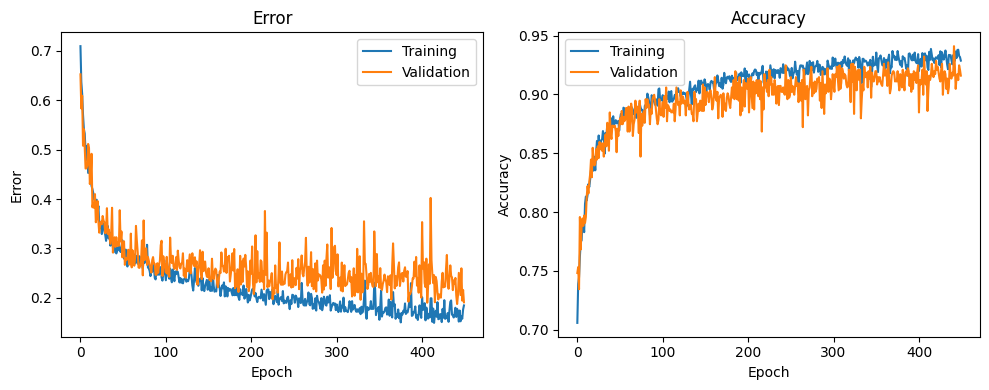

In [ ]:
#Training charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Error
ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Error')
ax1.legend()

# Accuracy
ax2.plot(history.history['accuracy'], label='Training')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Predict on the testing_set
neural_net_test = testing_set.copy()
training_set = data_info.copy()

neural_net_test = fill_red_cards_test(neural_net_test, training_set)
team_column = neural_net_test['Team']
neural_net_test = delete_reduntant_columns(neural_net_test)
neural_net_test = encode_dominant_team(neural_net_test)

neural_net_test_scaled = scaler.fit_transform(neural_net_test)

In [ ]:
predictions = model.predict(neural_net_test_scaled, batch_size=32)
predictions = np.argmax(predictions, axis=1)
test_data = neural_net_test.copy()
test_data['Expected_position'] = predictions
neural_link_pred = predictions.copy()
test_data['Team'] = team_column
print(test_data[['Team','Season','Expected_position']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
                Team  Season  Expected_position
0            Arsenal    2324                  0
1        Aston Villa    2324                  1
2        Bournemouth    2324                  2
3          Brentford    2324                  1
4           Brighton    2324                  2
5            Burnley    2324                  3
6            Chelsea    2324                  1
7     Crystal Palace    2324                  2
8            Everton    2324                  2
9             Fulham    2324                  2
10         Liverpool    2324                  0
11             Luton    2324                  3
12          Man City    2324                  0
13        Man United    2324                  1
14         Newcastle    2324                  0
15     Nott'm Forest    2324                  2
16  Sheffield United    2324                  3
17         Tottenham    2324                  1
18          West Ham    2324                  3
19

In [ ]:
#Generate a table to compare both models' results
display_test_set['Tree position'] = tree_predictions
display_test_set['Neural Net position'] = neural_link_pred
display_test_set['Team'] = team_column
display_test_set

NameError: name 'neural_link_pred' is not defined

In [ ]:
#Download the test set with predictions
display_test_set.to_csv('dataset.csv', index=False)
files.download('dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>